# WindTurbine Power Prediction Model with Keras and TensorFlow

Producing a model that accurately **predicts wind turbine power** output from **wind speed values**, as in a given data set.

### Packages

In [1]:
import numpy as np

# mlp with scaled outputs on the regression problem
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
import pandas as pd

import matplotlib.pyplot as plt
#%matplotlib notebook
import seaborn as sns
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
plt.style.use('fivethirtyeight')
# https://scipy-lectures.org/intro/scipy/auto_examples/plot_curve_fit.html
# to plot curve on scatter plt
from scipy.optimize import curve_fit


import seaborn as sns
from IPython.display import HTML, display

## Keras and TensorFlow

Deep Neural Networks are Neural Networks with layers of nodes stacked on top of each other to transfer data to high-level functions/models[1]. Tensorflow is a evast library used in developing Deep Learinging models[3]. Keras is a deep learning library, built on TensorFlow, written in Python and with over 375000 users (as of early 2020)[2]. It is user friendly, allowing to quickly build neural networks[4].

<img src='https://www.upgrad.com/blog/wp-content/uploads/2019/04/keras-tensorflow-logo.jpg' alt="Keras+TensorFlow">

[1] https://www.kdnuggets.com/2020/02/deep-neural-networks.html

[2] https://keras.io/why_keras/

[3]https://github.com/tensorflow/tensorflow

[4]https://www.upgrad.com/blog/the-whats-what-of-keras-and-tensorflow/#:~:text=Keras%20is%20a%20high%2Dlevel,Python)%20for%20building%20Neural%20Networks.
(image[4])

## Importing the Data

The data consisted or 500 rows of data with 2 columns **speed** and **power**.

In [2]:
#Load in the dataset and show the first 10 reows
df = pd.read_csv('powerproduction.csv')
#sample the first 5 rows
df.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


## Data Visualization of Wind Turbine Data

In [3]:
#return the number of rows and colums
#display the info on the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   500 non-null    float64
 1   power   500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB
None


### Plot graph


In [4]:
# https://towardsdatascience.com/data-visualization-using-matplotlib-16f1aae5ce70
labels = list(df.axes[1])
speed = df[labels[0]].values
power = df[labels[1]].values


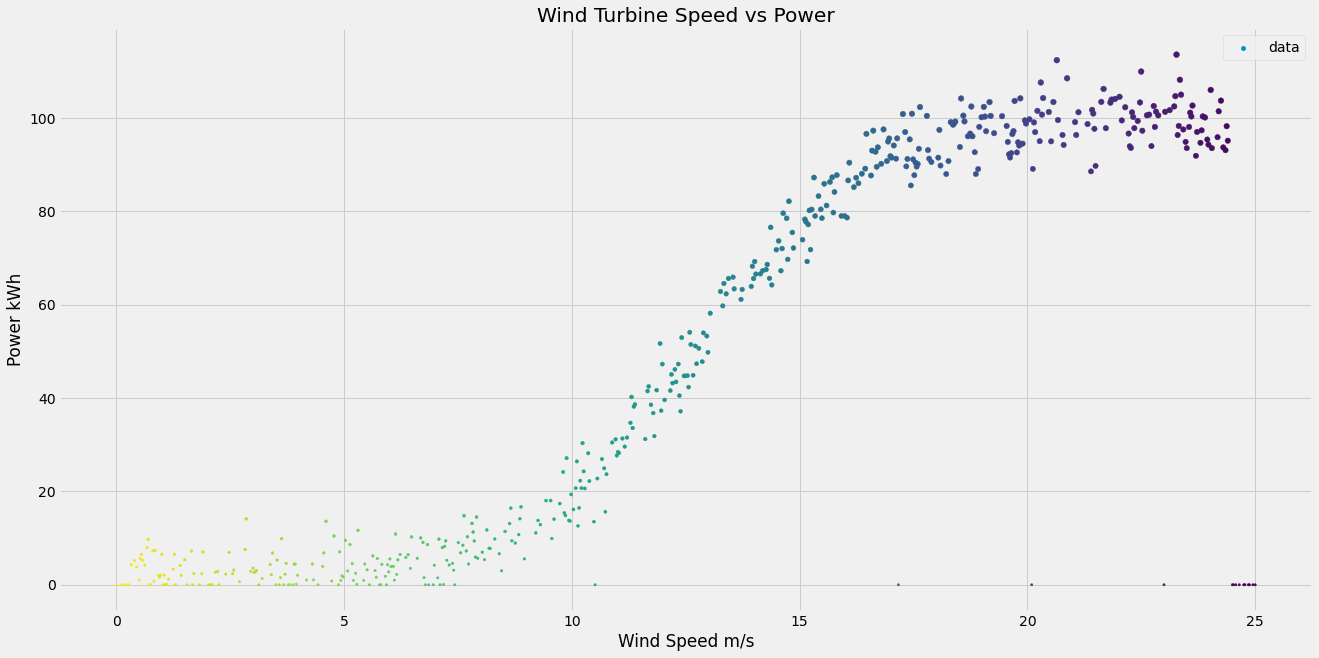

In [5]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.scatter.html
def plot_scatter():
    plt.figure(figsize=(20,10))
    plt.scatter(speed,power, marker=  ".", label="data",c=-speed, s=power+20)
    plt.xlabel('Wind Speed m/s')
    plt.ylabel('Power kWh')
    plt.title('Wind Turbine Speed vs Power')
    plt.legend()
    plt.show()

plot_scatter()

<Figure size 1440x1440 with 0 Axes>

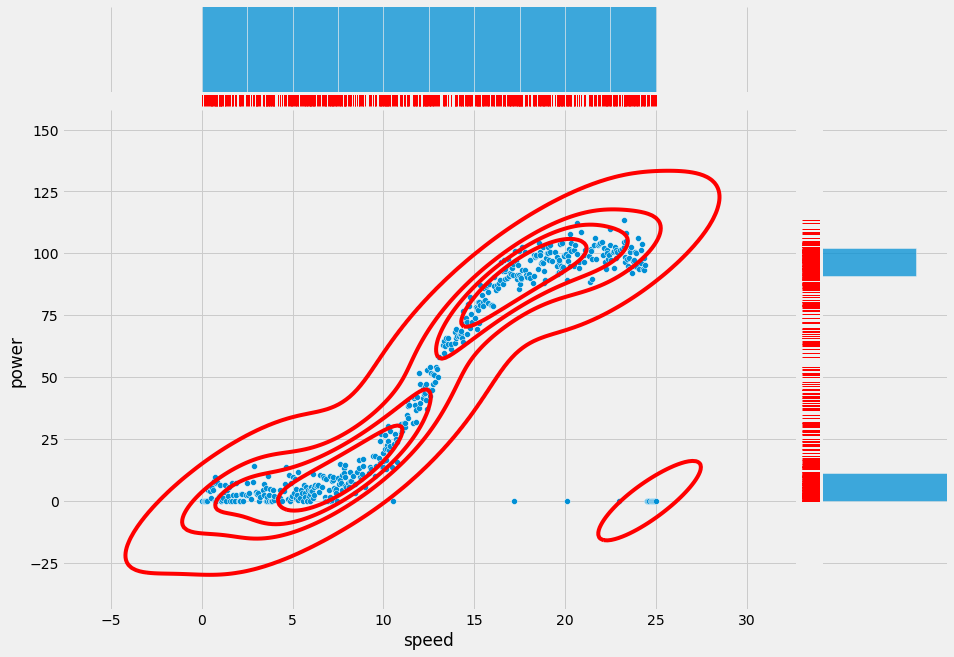

In [6]:
def plot_joint():
    # Set figure size (width, height) in inches  
    fig = plt.figure(figsize = (20 , 20 )) 
    g = sns.jointplot(data=df, x="speed", y="power")
    g.plot_joint(sns.kdeplot, color="r", zorder=1, levels=5)
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.fig.set_size_inches(15,10)

plot_joint()

### Data remarks

An assumption for the measurement for speed of the wind in m/s and that the WindTurbines are the smaller ones that produce a maximum of just over 100kW/hr[4] [5]. There seems to be some false data that needs to be cleaned out between 10-25 m/s where no power was detected. Storm winds of 25m/s [6] must be the cut-off speed for collecting power with this type of wind turbine (dangerous winds) , so our model should predict 0 power with speeds > 25m/s [7]. So that it doesn't effect prediction, we will remove the data past wind speeds of 25m/s.

The Data itself is shaped like a sigmoid curve.

[4] http://www.iwea.ie/technicalfaqs#:~:text=Wind%20turbines%20typically%20start%20operating,or%2025%2D30%20mph)

[5] #https://www.renewablesfirst.co.uk/windpower/windpower-learning-centre/much-power-generate-wind-turbine/#:~:text=For%20example%2C%20a%20wind%20turbine,of%202.5%20to%203%20MW.

[6] https://en.wind-turbine-models.com/winds

[7] https://www.wind-watch.org/wiki/Wind_turbine#:~:text=The%20rated%20speeds%20are%20~11,the%20blades%20turning%20in%20anticipation.

## DataOptimization

In [7]:
#sort by speed
zero_power_values = df.loc[(df['power'] == 0.0)]
print("Number of Data values with power value of 0.0 : ", len(zero_power_values))
df.sort_values(['speed']).tail(15)

Number of Data values with power value of 0.0 :  49


,speed,power
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223
489,24.399,95.117
490,24.499,0.000
491,24.525,0.000
492,24.575,0.000
493,24.650,0.000
494,24.750,0.000


### Remove  rows with Power Values == 0

There are 49 values with power showing 0. We can assume that when the turbine is working that we shouldn't see 0power so we will remove these values.

In [8]:
df = df.loc[(df['power'] > 0.0)]
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,451.0,13.004302,6.835979,0.325,7.3445,13.038,18.7815,24.399
power,451.0,53.231246,40.522055,0.067,8.5435,58.168,94.7255,113.556


### Look for Duplicate Speed Values

In [9]:
## Opimizing the Data
#Check for unique
print("Unique Speed: ", len(df.speed.unique()))
print("Unique Power: ", len(df.power.unique()))
#remove duplicated power( taking the first)
df = df.drop_duplicates(subset=['power'])
df.describe().transpose()

Unique Speed:  451
Unique Power:  450


,count,mean,std,min,25%,50%,75%,max
speed,450.0,12.993549,6.839768,0.325,7.32575,13.0130,18.78775,24.399
power,450.0,53.146716,40.527327,0.067,8.50725,56.1235,94.75275,113.556


In [10]:
labels = list(df.axes[1])
speed = df[labels[0]].values
power = df[labels[1]].values



### Plot Optimised Data

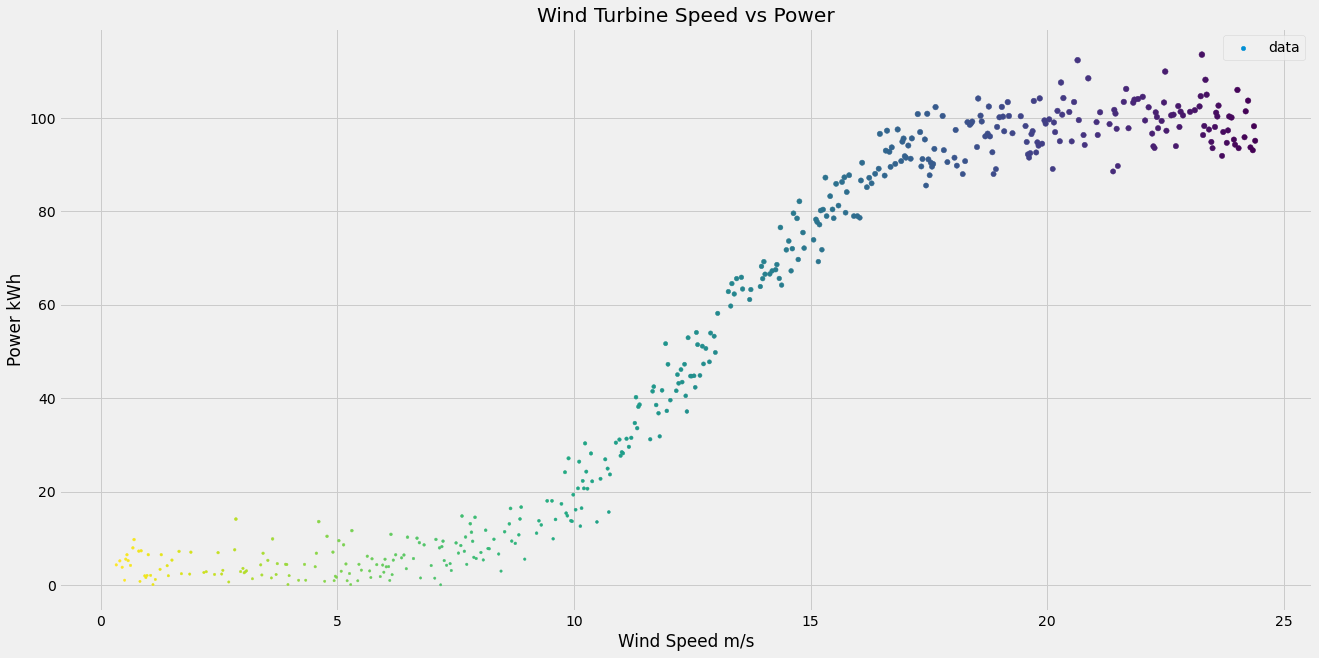

<Figure size 1440x1440 with 0 Axes>

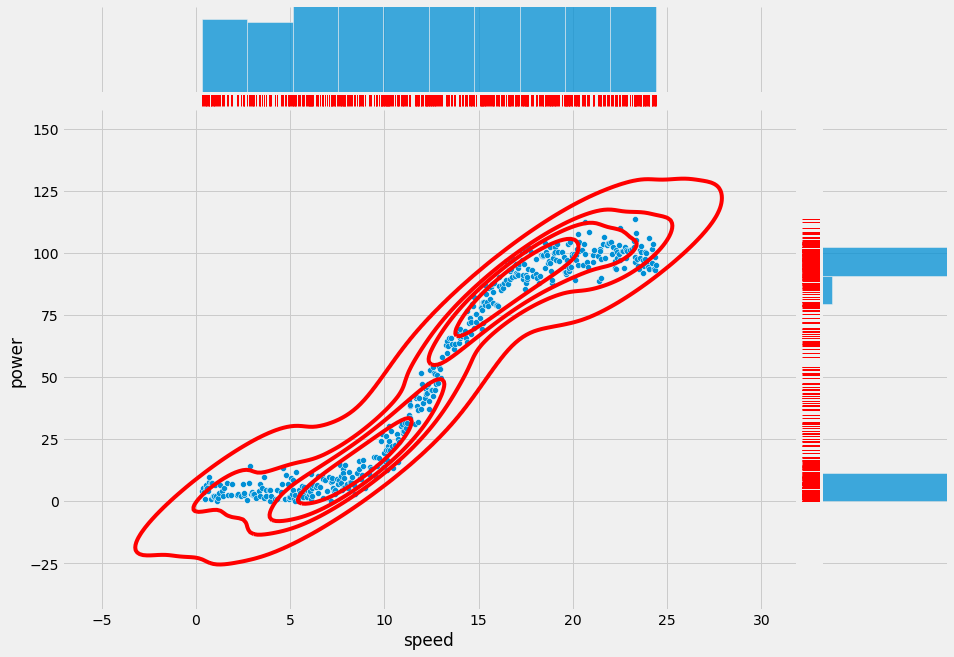

In [11]:
plot_scatter()
plot_joint()

## Sigmoid Curve




#### Sigmoid function

In [12]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

#### Curve_fit Sigmoid Curve

Using scipys **curve_fit** to plot the sigmoid curve on our graph

[6] https://machinelearningmastery.com/curve-fitting-with-python/

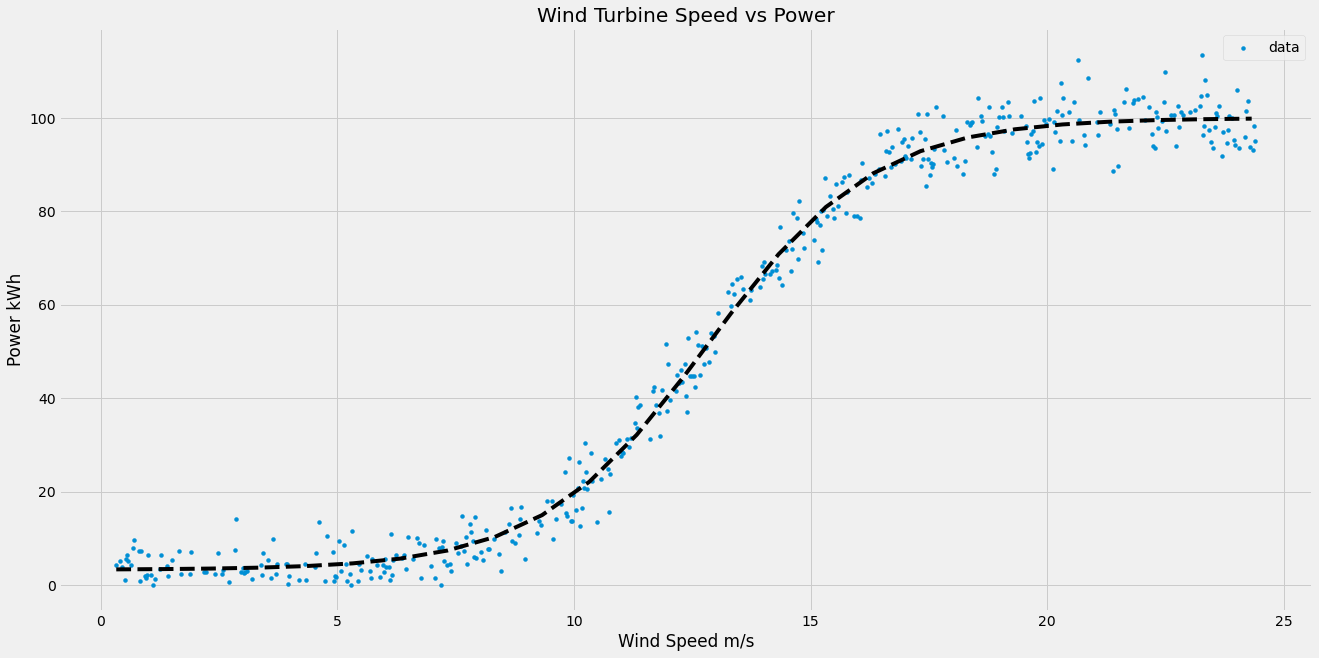

In [13]:
plt.figure(figsize=(20,10))
plt.scatter(speed,power, s=15, label="data");

#plt.scatter(speed,power, marker=  ".", label="data")
# Se
# https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509
# https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
p0 = [max(power), np.median(speed),1,min(power)]
popt, pcov = curve_fit(sigmoid, speed, power,p0, method='dogbox')

#plot the curve
x_line = np.arange(min(speed), max(speed), 1)
# calculate the output for the range
# Use the optimized parameters to plot the best fit
y_line = sigmoid(x_line,*popt)

# Plot the fit data as an overlay on the scatter data
# create a line plot for the mapping function
plt.plot(x_line, y_line, '--', color='k')


#Add the Titles
plt.xlabel('Wind Speed m/s')
plt.ylabel('Power kWh')
plt.title('Wind Turbine Speed vs Power')
plt.legend()
# Show the graph
plt.legend()
plt.show()

## Pre-Processing the dataset

Nomalizing the data is recommended, and is standard practice when working with deep learning neural networks [8].   

[8]https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

[9] https://www.tensorflow.org/tutorials/keras/regression

### Spliting the data

The train and test "labels" are the **power** values, which will be seperated as this is the value the model will predict. [9]

In [14]:
#test_size 0.2 splits it into a 80:20 split
X_train, X_test, y_train, y_test = train_test_split(
    speed, power, test_size=0.2, random_state=0)

#size of training and test datasets
print("Training set size: ",len(X_train))
print("Test set size: ", len(X_test))

#y_test = y_test.reshape(len(y_test), 1)
#y_test

Training set size:  360
Test set size:  90


### Scale/Normalise values

https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

In [15]:
 # created scaler
scaler = StandardScaler()
def scaleData(data):
    #reshape 1d arrays to 2d arrays
    data = data.reshape(len(data), 1)
    # fit scaler on  dataset
    scaler.fit(data)
    # transform  dataset
    data = scaler.transform(data)
    return data



#reshape 1d arrays to 2d arrays
#y_train = y_train.reshape(len(y_train), 1)
#y_test = y_test.reshape(len(y_test), 1)
# created scaler
#scaler = StandardScaler()
# fit scaler on training dataset
#scaler.fit(y_train)
#scaler.fit(y_test)
# transform training dataset
##y_train = scaler.transform(y_train)
# transform test dataset
#y_test = scaler.transform(y_test)

y_test = scaleData(y_test)
y_train = scaleData(y_train)
#X_test = scaler.inverse_transform(X_test)
#y_test= scaler.inverse_transform(y_test)


#### Normalization

In [16]:
#create a layer and then adapt the training data to it
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

[12.927789]


In [17]:
first = np.array(X_train[:1])
with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [3.63]

Normalized: [[-1.36]]


## Linear Regression

In [18]:
power_features = np.array(X_train)
power_normalizer = preprocessing.Normalization(input_shape=[1,])
power_normalizer.adapt(power)

Build the sequential model by applying  a ReLu transformation to produce 1 output using Dense()

In [19]:
power_linear_model = Sequential([
    power_normalizer,
    Dense(units=1)
])

power_linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


#### train 

In [20]:
power_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [21]:
%%time
history = power_linear_model.fit(
    X_train, y_train,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 6.47 s


In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.273136,0.270402,95
96,0.276474,0.271109,96
97,0.277912,0.285710,97
98,0.271968,0.276583,98
99,0.285809,0.276660,99


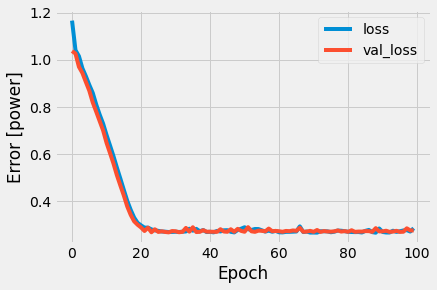

In [23]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [power]')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)

In [24]:
test_results = {}

test_results['power_linear_model'] = power_linear_model.evaluate(
    X_test,
    y_test, verbose=0)

test_results

{'power_linear_model': 0.32450610399246216}

In [25]:
x = tf.linspace(0.0, 25, 25)
y = power_linear_model.predict(x)

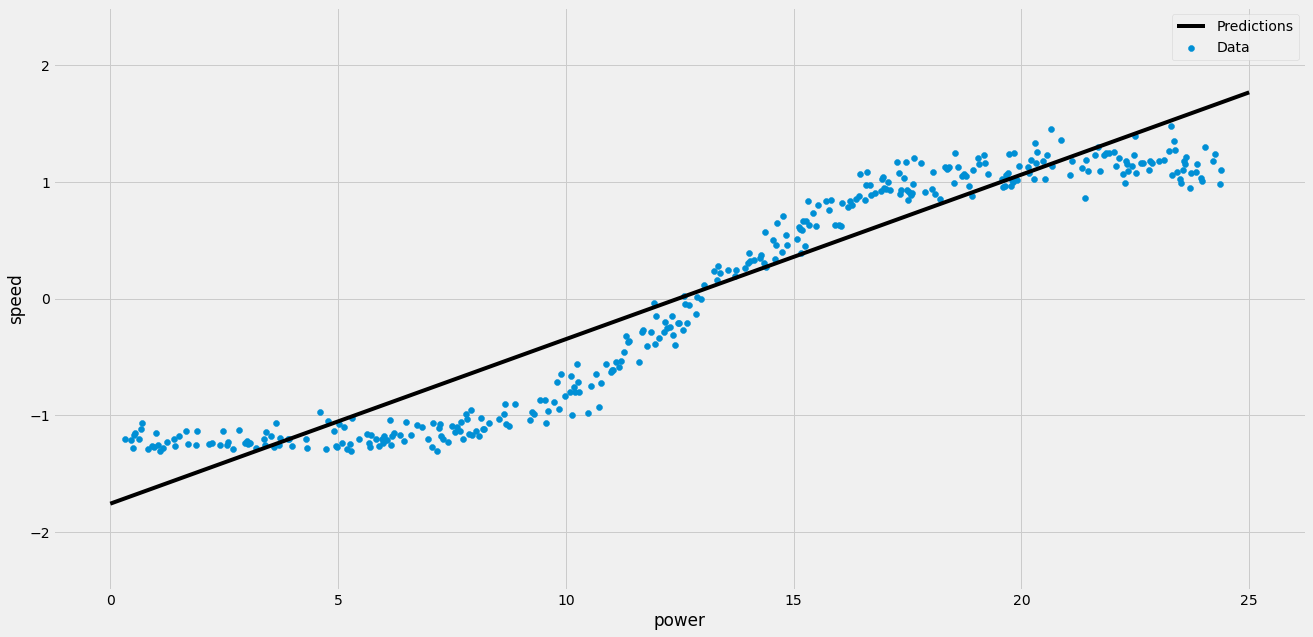

In [26]:
def plot_power(x, y):
    plt.figure(figsize=(20,10))
    plt.scatter(X_train, y_train, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.ylim([-2.5, 2.5])
    plt.xlabel('power')
    plt.ylabel('speed')
    plt.legend()

plot_power(x,y)

## DNN Regression

## Wind Turbine Model

Create a squential model of our windturbine using the power and speed varibales

    1. The model expects to see rows with 2 varibales (*input_dim=2*)
    2. The first layer to have 12 nodes using the ReLU function 
    3. The second layer has 8 

In [27]:
# define the keras model
dnn_power_model = Sequential([
        power_normalizer,
        Dense(64, input_dim=1, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
])

Where the d

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

In [28]:
# compile the keras model
dnn_power_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [29]:
dnn_power_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [30]:
%%time
history = dnn_power_model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=0, 
    epochs=350)

Wall time: 8.12 s


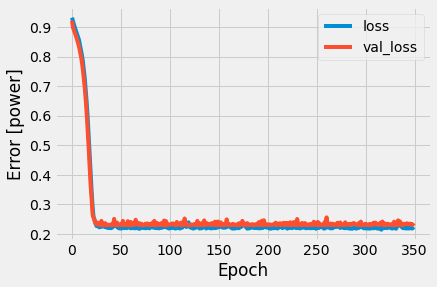

In [31]:
plot_loss(history)

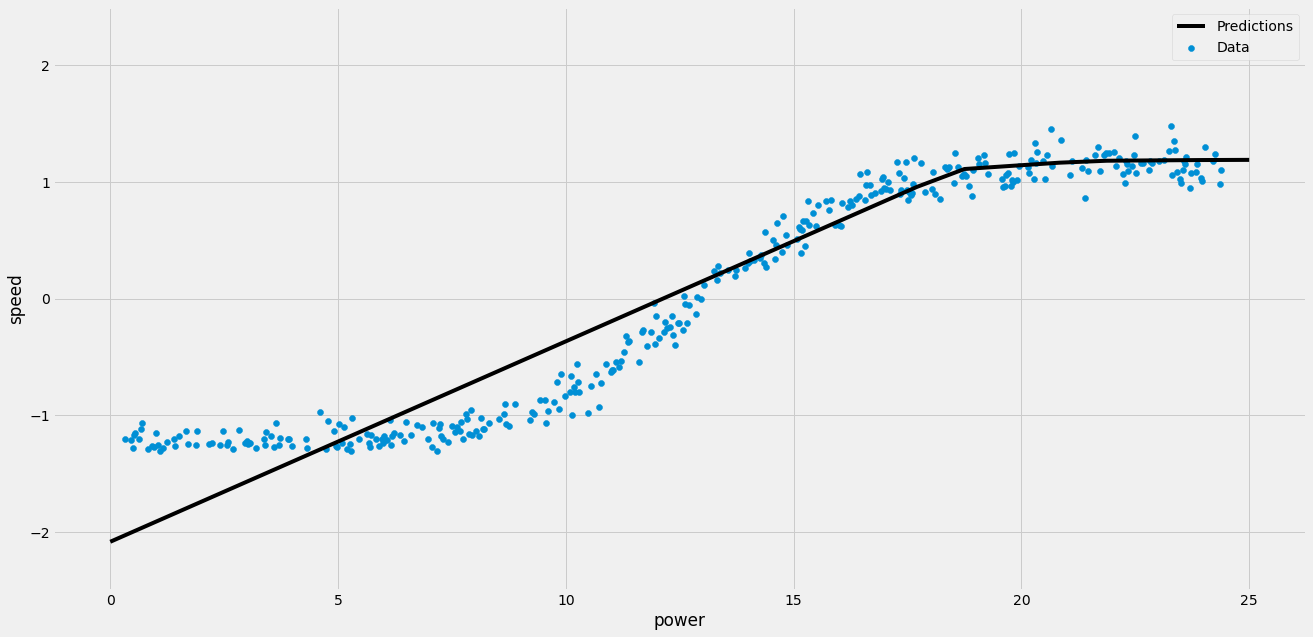

In [32]:
x1 = tf.linspace(0.0, 25, 25)
y1 = dnn_power_model.predict(x1)
plot_power(x1,y1)

In [33]:
# evaluate the model
test_mse = dnn_power_model.evaluate(X_test, y_test, verbose=0)
train_mse = dnn_power_model.evaluate(X_train, y_train, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.223, Test: 0.250


In [34]:
print(metrics.mean_squared_error(y_test, dnn_power_model.predict(X_test)))

0.1102671589014046


## Save the Power Model

In [35]:
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# serialize model to JSON
model_json = dnn_power_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dnn_power_model.save("model.h5")
print("Saved model to disk")

Saved model to disk
